In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import gc
import pickle

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from fastai.vision.all import *
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
FOLDS = [1,2,3,4,5]
PATCH_SIZE = 512
patch_size = 64
Lmax = 5
BS = 64
EPOCHS = 5
SEED = 777
level_swap = .1
SWAPS = [[1,2],[2,3]]

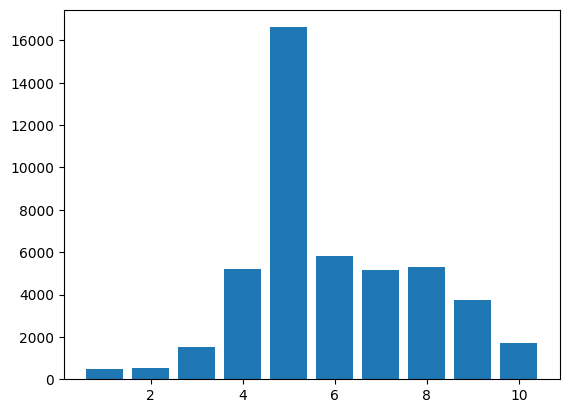

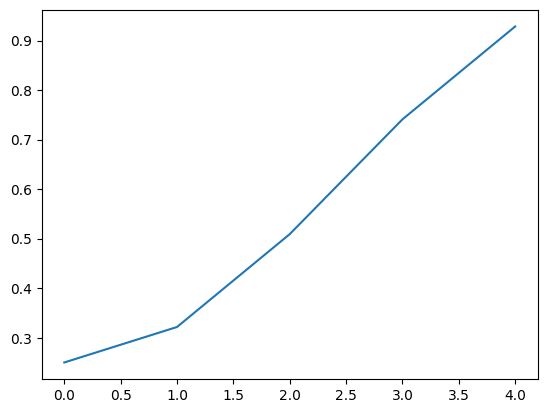

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# CosineAnnealingAlpha
def nt(nmin,nmax,tcur,tmax):
    return (nmax - .5*(nmax-nmin)*(1+np.cos(tcur*np.pi/tmax))).astype(np.float32)

plt.plot(nt(.25,1,np.arange(EPOCHS),EPOCHS))
plt.show()

# callback to update alpha during training
def cb(self):
    alpha = torch.as_tensor(nt(.25,1,learn.train_iter,EPOCHS*n_iter))
    learn.dls.train_ds.alpha = alpha
alpha_cb = Callback(before_batch=cb)

def augment_image(image,alpha):
#   Randomly rotate the image.
    angle = torch.as_tensor(random.uniform(-180, 180)*alpha)
    image = torchvision.transforms.functional.rotate(image,angle.item())#,interpolation=torchvision.transforms.InterpolationMode.BILINEAR)

    return image
# To better center spine I consider L and R as the two superior vertices of an inverted equilateral triangle
# and I find the 3rd vertex adding to one of them the 60 degree rotated vector that unites them
# With those 3 vertices the Icenter is just (A + B + C)/3
angle = -60
theta = (angle/180.) * np.pi

rotMatrix = torch.as_tensor([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
]).float().to(device)

In [4]:
spinal = [
    'spinal_canal_stenosis_l1_l2',
    'spinal_canal_stenosis_l2_l3',
    'spinal_canal_stenosis_l3_l4',
    'spinal_canal_stenosis_l4_l5',
    'spinal_canal_stenosis_l5_s1'
]

labels = {
    'Normal/Mild':0,
    'Moderate':1,
    'Severe':2,
    'UNK':-100
}

available_flips = [[True],[False]]
for _ in range(4): available_flips = [v+[True] for v in available_flips]+[v+[False] for v in available_flips]

In [5]:
train = pd.read_csv('dataset/train_split.csv')
train = train[['study_id','fold'] + spinal]
train.tail()

,study_id,fold,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1
1970,4282019580,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1971,4283570761,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,5.0,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild
1974,4290709089,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


In [6]:
train = train.fillna('UNK')
train[(train[spinal] == 'UNK').sum(1)>0].reset_index(drop=True).tail()

,study_id,fold,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1
0,3008676218,4.0,UNK,UNK,UNK,UNK,UNK


In [7]:
with open('dataset/axial_centers.pkl', 'rb') as f:
    coord = pickle.load(f)

with open('dataset/level_assignments.pkl', 'rb') as f:
    assignments = pickle.load(f)

In [8]:
df = pd.DataFrame({'key':assignments.keys()})
df['study_id'] = df['key'].apply(lambda v:int(v.split('_')[0]))
df['series_id'] = df['key'].apply(lambda v:int(v.split('_')[-1]))
df.tail()

,key,study_id,series_id
2224,4282019580_1547999333_121051321,4282019580,121051321
2225,4283570761_453728183_3321662903,4283570761,3321662903
2226,4284048608_3767301072_3891595425,4284048608,3891595425
2227,4287160193_1507070277_1820446240,4287160193,1820446240
2228,4290709089_3274612423_3390218084,4290709089,3390218084


In [9]:
df = df.merge(train,left_on='study_id',right_on='study_id')
df.tail()

,key,study_id,series_id,fold,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1
2224,4282019580_1547999333_121051321,4282019580,121051321,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
2225,4283570761_453728183_3321662903,4283570761,3321662903,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
2226,4284048608_3767301072_3891595425,4284048608,3891595425,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
2227,4287160193_1507070277_1820446240,4287160193,1820446240,5.0,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild
2228,4290709089_3274612423_3390218084,4290709089,3390218084,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


In [10]:
df = df[df[spinal].isna().sum(1) < 5]

In [11]:
df['flip'] = False
fdf = df.copy()
fdf['flip'] = True
df = pd.concat([df,fdf]).reset_index(drop=True)
df.tail()

,key,study_id,series_id,fold,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,flip
4453,4282019580_1547999333_121051321,4282019580,121051321,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,True
4454,4283570761_453728183_3321662903,4283570761,3321662903,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,True
4455,4284048608_3767301072_3891595425,4284048608,3891595425,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,True
4456,4287160193_1507070277_1820446240,4287160193,1820446240,5.0,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,True
4457,4290709089_3274612423_3390218084,4290709089,3390218084,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,True


In [12]:
class subarticular_Dataset(Dataset):
    def __init__(self, df, f, VALID=False, P=patch_size, alpha=0):
        self.data = df
        self.VALID = VALID
        self.f = f
        self.P = P
        self.alpha = alpha
        self.resize = torchvision.transforms.Resize((PATCH_SIZE,PATCH_SIZE),antialias=True)
        self.indices = torch.arange(Lmax).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        row = self.data.iloc[index]
        
        sample = 'C:/Users/TCrepin/perso/Projects/RSNA-Lumbar-Spine-Conditions-Severity-Prediction/dataset/train_images/'
        sample = sample+str(int(row['study_id']))+'/'+str(int(row['series_id']))

        images = [x.replace('\\','/') for x in glob.glob(sample+'/*.dcm')]
        images.sort(key=lambda k:int(k.split('/')[-1].replace('.dcm','')))
        instance_numbers = [int(k.split('/')[-1].replace('.dcm','')) for k in images]
        images = [torch.as_tensor(pydicom.dcmread(img).pixel_array.astype('float32')) for img in images]
        shapes = [img.shape for img in images]
        H,W = np.array(shapes).max(0)

        images = torch.concat([torch.nn.functional.pad(
            images[k].unsqueeze(0),(
                (W - shapes[k][-1])//2,
                (W - shapes[k][-1]) - (W - shapes[k][-1])//2,
                (H - shapes[k][-2])//2,
                (H - shapes[k][-2]) - (H - shapes[k][-2])//2
            ),
        mode='reflect') for k in range(len(images))]).float()

        if H > W:
            d = W
            h = (H - d)//2
            images = images[:,h:h+d]
            H = W
        elif H < W:
            d = H
            w = (W - d)//2
            images = images[:,:,w:w+d]
            W = H

        images = self.resize(images/images.max()).float().to(device)

        c = coord[self.f][row['study_id']][row['series_id']].clone()

        c[c < 64] = torch.nan
        c[c > 512 - 64] = torch.nan
        c = torch.cat([
            c,
            (c[:,1] + torch.matmul(c[:,0] - c[:,1],rotMatrix)).unsqueeze(1)
        ],1)
        c_mean = torch.nanmean(c, dim=0)
        instance_to_k = {instance_numbers[k]:k for k in range(len(c))}
        
        img = torch.zeros(5,Lmax,128,128)
        slices_mask = torch.ones(5,Lmax).bool()
        for k in [1,2,3,4,5]:
            instance_numbers = assignments[row['key']][k]['instance_numbers']
            if len(instance_numbers) == 0: continue
            distances = assignments[row['key']][k]['dis']
            dis_sign = np.sign(distances)
            if dis_sign[0] != dis_sign[-1]:
                c_k = torch.stack([c[instance_to_k[i]] for i in instance_numbers])
                c_k_mean = torch.nanmean(c_k, dim=0)
                mask =  torch.isnan(c_k_mean)
                c_k_mean[mask] = c_mean[mask]
                c_k_mean = c_k_mean.unsqueeze(0).tile(len(c_k),1,1)
                mask = torch.isnan(c_k)
                c_k[mask] = c_k_mean[mask]
                    
                c_spine = c_k.mean(1)
                '''print(c_mean)
                print(c_k_mean)
                print(c_k)
                print(c_spine)'''
        
                images_k = torch.stack([
                        images[
                            instance_to_k[instance_numbers[i]],
                            c_spine[i,1].long()-self.P:c_spine[i,1].long()+self.P,
                            c_spine[i,0].long()-self.P:c_spine[i,0].long()+self.P
                        ] for i in range(len(distances))#instance_numbers
                ])

                if len(distances) > Lmax:
#                   abs_dist = [abs(v) for v in distances]
#                   abs_dist.sort()
#                   dis_th = abs_dist[Lmax]
#                   img[k-1] = images_k[:,abs(distances) < dis_th]
#                   slices_mask[k-1] = False
                    indices = [i for i in range(len(distances))]
                    indices.sort(key=lambda i:abs(distances[i]))
                    indices = indices[:Lmax]
                    indices.sort()
                    img[k-1] = images_k[indices]
                    slices_mask[k-1] = False

                else:
                    d = (Lmax - len(distances))//2
                    img[k-1,d:d+len(distances)] = images_k
                    slices_mask[k-1,d:d+len(distances)] = False

        images = img.view(-1,2*self.P,2*self.P)
        if not self.VALID:
            images = augment_image(images,self.alpha)[...,self.P//2:self.P//2+self.P,self.P//2:self.P//2+self.P]
        else:
            images = images[...,self.P//2:self.P//2+self.P,self.P//2:self.P//2+self.P]

        images = images.view(5,Lmax,self.P,self.P)
        
        label = torch.as_tensor([labels[x] for x in row[spinal]])
        label[slices_mask.sum(-1) == Lmax] = -100
        
        if row['flip']:
#            Flip L to R
            images = images.flip(-1)

        return [images.to(device),slices_mask.to(device)],label.to(device)

In [13]:
ds = subarticular_Dataset(df,1)

tensor([0, 0, 0, 0, 0], device='cuda:0')


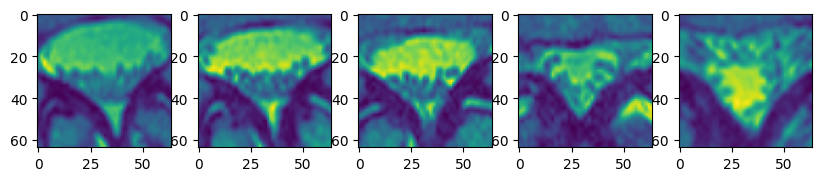

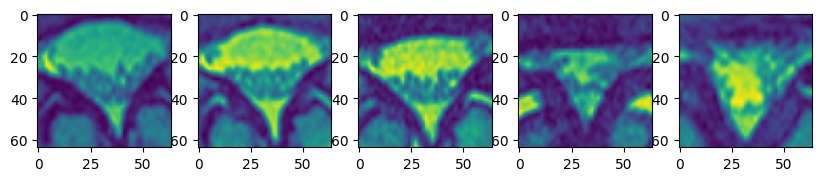

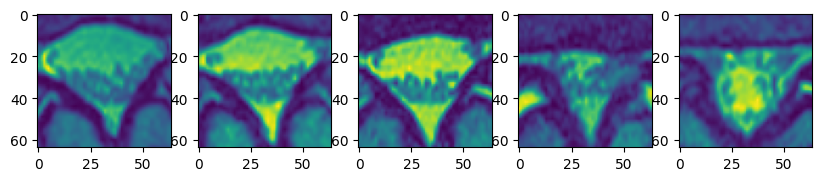

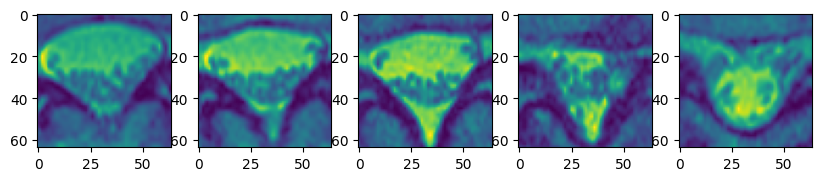

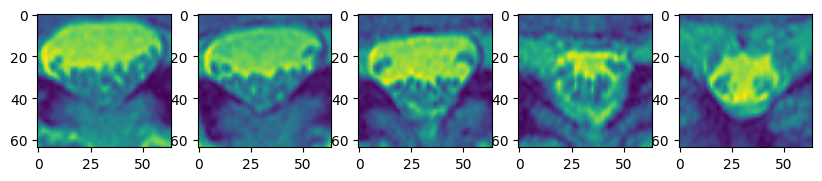

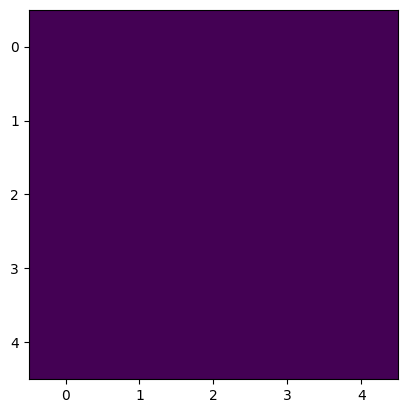

In [14]:
sample = ds.__getitem__(np.random.randint(len(ds)))
print(sample[1])
for i in range(5):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    for k in range(5):
        axes[k].imshow(sample[0][0][k][i].cpu())
    plt.show()
plt.imshow(sample[0][1].cpu().view(-1,Lmax))
plt.show()

In [15]:
class myUNet(nn.Module):
    def __init__(self):
        super(myUNet, self).__init__()

        self.UNet = smp.Unet(
            encoder_name="resnet18",
            classes=2,
            in_channels=1
        ).to(device)

    def forward(self,X):
        x = self.UNet(X)
#       MinMaxScaling along the class plane to generate a heatmap
        min_values = x.view(-1,2,PATCH_SIZE*PATCH_SIZE).min(-1)[0].view(-1,2,1,1) # Bug, I've been MinMaxScaling with the wrong values
        max_values = x.view(-1,2,PATCH_SIZE*PATCH_SIZE).max(-1)[0].view(-1,2,1,1)
        x = (x - min_values)/(max_values - min_values)
        
        return x

In [16]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim=16, M=10000):
        super().__init__()
        self.dim = dim
        self.M = M

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.M) / half_dim
        emb = torch.exp(torch.arange(half_dim, device=device) * (-emb))
        emb = x[...,None] * emb[None,...]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class myViT(nn.Module):
    def __init__(self, ENCODER, dim=512, depth=24, head_size=64, **kwargs):
        super().__init__()
        self.ENCODER = ENCODER
        self.AvgPool = nn.AdaptiveAvgPool2d(output_size=1).to(device)
        self.slices_pos_enc = nn.Parameter(SinusoidalPosEmb(dim)(torch.arange(Lmax, device=device).unsqueeze(0)))
        self.side_pos_enc = nn.Parameter(SinusoidalPosEmb(dim)(torch.arange(2, device=device).unsqueeze(0)))
        self.level_pos_enc = nn.Parameter(SinusoidalPosEmb(dim)(torch.arange(5, device=device).unsqueeze(0)))
        self.slices_transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), 24)
        self.side_transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), 12)
        self.level_transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), 12)
        self.proj_out = nn.Linear(dim,3).to(device)
    
    def forward(self, x):
        x,slices_mask = x
        
        '''for kk in range(BS):
            fig, axesL = plt.subplots(1, 5, figsize=(10,10))
            fig, axesR = plt.subplots(1, 5, figsize=(10,10))
            for k in range(5):
                axesL[k].imshow(x[kk,k,0].sum(0).cpu())
                axesR[k].imshow(x[kk,k,1].sum(0).cpu())
            plt.show()'''
        
        x = self.ENCODER(x.view(-1,1,patch_size,patch_size))[-1]
        x = self.AvgPool(x)
        slices_mask = slices_mask.view(-1,Lmax)
        mask = slices_mask.sum(-1) < Lmax
        x = x.view(-1,Lmax,512) + self.slices_pos_enc
        x[mask] = self.slices_transformer(x[mask],src_key_padding_mask=slices_mask[mask])
        x[slices_mask] = 0
        d = (~slices_mask).sum(1).unsqueeze(-1).tile(1,512)
        x = x.sum(1)
        x[d > 0] = x[d > 0]/d[d > 0]

        side_mask = slices_mask.view(-1,2,Lmax).sum(-1) == Lmax
        mask = side_mask.sum(-1) < 2
        x = x.view(-1,2,512) + self.side_pos_enc
        x[mask] = self.side_transformer(x[mask],src_key_padding_mask=side_mask[mask])

        level_mask = side_mask.view(-1,5,2).permute(0,2,1).reshape(-1,5)
        mask = level_mask.sum(-1) < 5
        x = x.view(-1,5,2,512).permute(0,2,1,3).reshape(-1,5,512)
        x = x + self.level_pos_enc
        x[mask] = self.level_transformer(x[mask],src_key_padding_mask=level_mask[mask])

        x = self.proj_out(x.view(-1,512)).view(-1,2,5,3)

        return x
    
class AxialSpinalViT(nn.Module):
    def __init__(
        self,
        ENCODER,
        slices_pos_enc,
        level_pos_enc,
        slices_transformer,
        level_transformer,
        proj_out,
        dim=512, depth=24, head_size=64, **kwargs
    ):
        super().__init__()
        self.ENCODER = ENCODER
        self.AvgPool = nn.AdaptiveAvgPool2d(output_size=1).to(device)
        self.slices_pos_enc = slices_pos_enc
        self.level_pos_enc = level_pos_enc
        self.slices_transformer = slices_transformer
        self.level_transformer = level_transformer
        self.proj_out = proj_out
    
    def forward(self, x):
        x,slices_mask = x
        
        '''for kk in range(BS):
            fig, axes = plt.subplots(1, 5, figsize=(10,10))
            for k in range(5):
                axes[k].imshow(x[kk,k].sum(0).cpu())
            plt.show()'''
        
        x = self.ENCODER(x.view(-1,1,patch_size,patch_size))[-1]
        x = self.AvgPool(x)
        slices_mask = slices_mask.view(-1,Lmax)
        mask = slices_mask.sum(-1) < Lmax
        x = x.view(-1,Lmax,512) + self.slices_pos_enc
        x[mask] = self.slices_transformer(x[mask],src_key_padding_mask=slices_mask[mask])
        x[slices_mask] = 0
        d = (~slices_mask).sum(1).unsqueeze(-1).tile(1,512)
        x = x.sum(1)
        x[d > 0] = x[d > 0]/d[d > 0]

        level_mask = slices_mask.view(-1,5,Lmax).sum(-1) == Lmax
        mask = level_mask.sum(-1) < 5
        x = x.view(-1,5,512) + self.level_pos_enc
        x[mask] = self.level_transformer(x[mask],src_key_padding_mask=level_mask[mask])

        x = self.proj_out(x.view(-1,512)).view(-1,5,3)

        return x

In [17]:
def myLoss(preds,target):
    target = target.view(-1)
    preds = preds.view(-1,3)
    Loss = nn.CrossEntropyLoss(weight=torch.as_tensor([1.,2.,4.]).to(device))(preds,target.long())
    return Loss

epoch,train_loss,valid_loss,time
0,0.336214,0.307708,30:27
1,0.307371,0.302324,29:42
2,0.290530,0.325181,29:20


Better model found at epoch 0 with valid_loss value: 0.3077077865600586.


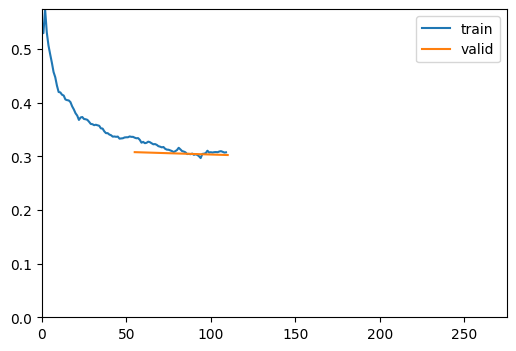

Better model found at epoch 1 with valid_loss value: 0.3023238480091095.

No improvement since epoch 1: early stopping


epoch,train_loss,valid_loss,time
0,0.343494,0.307108,28:55
1,0.307652,0.291890,30:41
2,0.296704,0.276077,29:25
3,0.288972,0.276239,29:08


Better model found at epoch 0 with valid_loss value: 0.3071078360080719.


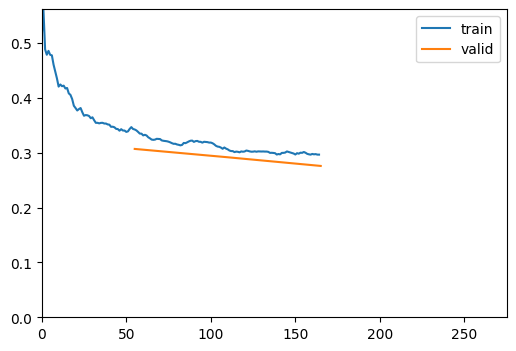

Better model found at epoch 1 with valid_loss value: 0.2918901741504669.

Better model found at epoch 2 with valid_loss value: 0.27607670426368713.

No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,time
0,0.371108,0.359279,28:46
1,0.340899,0.334131,29:15
2,0.333416,0.313057,29:16
3,0.338851,0.309129,29:02
4,0.336864,0.307419,29:12


Better model found at epoch 0 with valid_loss value: 0.3592788279056549.


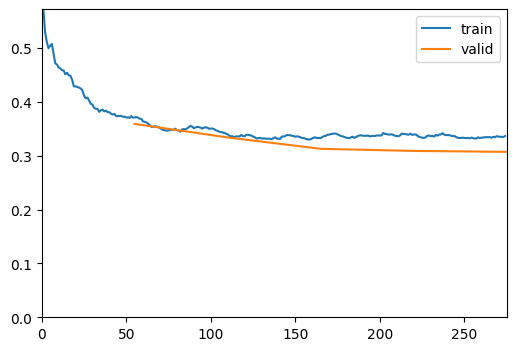

Better model found at epoch 1 with valid_loss value: 0.3341311514377594.

Better model found at epoch 2 with valid_loss value: 0.3130573332309723.

Better model found at epoch 3 with valid_loss value: 0.3091285228729248.

Better model found at epoch 4 with valid_loss value: 0.30741921067237854.


epoch,train_loss,valid_loss,time
0,0.330582,0.306216,30:28
1,0.312219,0.336232,30:07


Better model found at epoch 0 with valid_loss value: 0.3062160611152649.


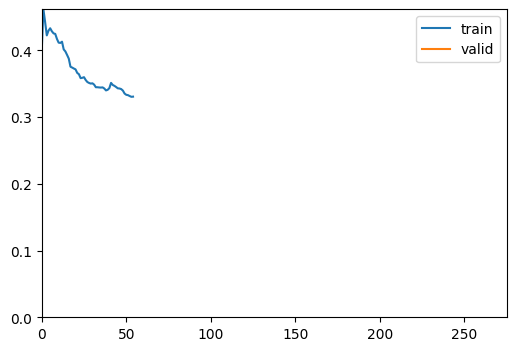

No improvement since epoch 0: early stopping


epoch,train_loss,valid_loss,time


RuntimeError: stack expects each tensor to be equal size, but got [0, 128] at entry 0 and [128, 128] at entry 1

In [18]:
for f in FOLDS:
    seed_everything(SEED)
    seg_model = myUNet()
    sub_model = torch.load('subarticular_DICOM_V2_ViT_'+str(f)) #sub_model = myViT(seg_model.UNet.encoder)#
    model = AxialSpinalViT(
        sub_model.ENCODER,
        sub_model.slices_pos_enc,
        sub_model.level_pos_enc,
        sub_model.slices_transformer,
        sub_model.level_transformer,
        sub_model.proj_out
    )
    
    tdf = df[df.fold != f]
    vdf = df[df.fold == f]
    tds = subarticular_Dataset(tdf,f)
    vds = subarticular_Dataset(vdf,f,VALID=True)
    tdl = torch.utils.data.DataLoader(tds, batch_size=BS, shuffle=True, drop_last=True)
    vdl = torch.utils.data.DataLoader(vds, batch_size=BS, shuffle=False)
    dls = DataLoaders(tdl,vdl)

    n_iter = len(tds)//BS

    learn = Learner(
        dls,
        model,
        loss_func=myLoss,
        cbs=[
            ShowGraphCallback(),
            GradientClip(3.0),
            SaveModelCallback (fname='spinal_DICOM_ViT_'+str(f)),
            EarlyStoppingCallback (patience=0),
            alpha_cb
        ]
    )
    learn.fit_one_cycle(EPOCHS, lr_max=5e-4
                        , wd=0.05, pct_start=0.02)
#   torch.save(model,'spinal_DICOM_ViT_'+str(f))
    del model,seg_model,sub_model,tdf,vdf,tds,vds,tdl,vdl,dls,learn
    gc.collect()